## Use case for LP optimization: discount level for alcoholic beverages

Data downloaded from https://www.kaggle.com/mrmorj/big-mart-sales



In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings('ignore')


def discount_bin(x):
    if x == 1:
        return '0%'
    if x >= 0.95:
        return '<=5%'
    if x > 0.9:
        return '5-10%'
    if x > 0.75:
        return '10-25%'
    if x > 0.5:
        return '25-50%'
    if x <= 0.5:
        return '>=50%'

In [3]:
data = pd.read_csv('src/big_mart_sales.csv')

data.drop(['Outlet_Establishment_Year', 'Outlet_Size', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility'], 1, inplace = True)
data['Outlet_Type'] = data['Outlet_Type'].apply(lambda x: 'Supermarket' if 'Supermarket' in x else x)

data['Quantity'] = (data['Item_Outlet_Sales'] / data['Item_MRP']).round(1).astype(int)
data['Price'] = data['Item_Outlet_Sales'] / data['Quantity']
data.rename(columns = {'Item_Outlet_Sales' : 'Sales'}, inplace = True)
data.drop(['Item_MRP'], 1, inplace = True)

data.head(3)

,Item_Identifier,Item_Type,Outlet_Identifier,Outlet_Location_Type,Outlet_Type,Sales,Quantity,Price
0,FDA15,Dairy,OUT049,Tier 1,Supermarket,3735.1380,15,249.0092
1,DRC01,Soft Drinks,OUT018,Tier 3,Supermarket,443.4228,9,49.2692
2,FDN15,Meat,OUT049,Tier 1,Supermarket,2097.2700,14,149.8050


### Step 1: Aggregate sales data by item type, outlet type by summing up quantity and sales, calculating mean price

Preprocessing step: calculate price range to add as aggregation hierarchy

In [4]:
max_price = data.groupby('Item_Identifier').agg({'Price' : 'max'}).reset_index().rename(columns={'Price' : 'Max_Price_Product'})
data = data.merge(max_price, on = 'Item_Identifier')

data['Discount'] = data['Price'] / data['Max_Price_Product']
data['Discount_Bin'] = data['Discount'].apply(lambda x: discount_bin(x))
data.drop(['Discount', 'Max_Price_Product'], 1, inplace = True)

data.head(3)

,Item_Identifier,Item_Type,Outlet_Identifier,Outlet_Location_Type,Outlet_Type,Sales,Quantity,Price,Discount_Bin
0,FDA15,Dairy,OUT049,Tier 1,Supermarket,3735.1380,15,249.009200,<=5%
1,FDA15,Dairy,OUT045,Tier 2,Supermarket,5976.2208,23,259.835687,0%
2,FDA15,Dairy,OUT035,Tier 2,Supermarket,6474.2392,26,249.009200,<=5%


Aggregation on item, outlet type and discount

In [5]:
groupby_cols = ['Item_Identifier', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type', 'Discount_Bin']
data_agg = data.groupby(groupby_cols).agg({'Sales' : 'sum', 'Quantity' : 'sum', 'Price' : 'mean'}).reset_index()
data_agg.rename(columns = {'Sales' : 'Total_Sales', 'Quantity' : 'Total_Quantity', 'Price' : 'Avg_Price'}, inplace = True)

data_agg.head(3)

,Item_Identifier,Item_Type,Outlet_Location_Type,Outlet_Type,Discount_Bin,Total_Sales,Total_Quantity,Avg_Price
0,DRA12,Soft Drinks,Tier 2,Supermarket,5-10%,7374.4008,52,141.815400
1,DRA12,Soft Drinks,Tier 3,Grocery Store,5-10%,283.6308,2,141.815400
2,DRA12,Soft Drinks,Tier 3,Supermarket,0%,2552.6772,17,150.157482


### Step 2: Calculate elasticities

Calculation will be carried out on item and item type levels so that high-p value items or positive-elasticity items can be overwritten by their respective group's coefficients

In [6]:
def apply_ols(data):

    regression_equation = 'log_quantity ~ log_price'
    elasticity_model = ols(regression_equation, data = data).fit()

    return elasticity_model

In [7]:
def calc_price_elas(data: pd.DataFrame, group_by_cols: list, group_by_model: list, model_name: str) -> dict: 

    df_agg = data.groupby(group_by_cols).agg({'Total_Quantity' : 'mean', 'Avg_Price' : 'mean'}).reset_index()
    df_agg['log_price'] = np.log(df_agg['Avg_Price'])
    df_agg['log_quantity'] = np.log(df_agg['Total_Quantity'])
    
    df_model = df_agg.groupby(group_by_model, as_index = True)
    df_out = df_agg[group_by_model].drop_duplicates() # this will be filled up with model results
    
    # apply model for all groups
    df_model = df_model.apply(lambda x: apply_ols(x))

    # fill up results table
    df_out['intercept_' + model_name] = [i.params['Intercept'] for i in df_model.values]
    df_out['price_elasticity_' + model_name] = [i.params['log_price'] for i in df_model.values]
    df_out['p_value_' + model_name] = [i.pvalues['log_price'] for i in df_model.values]
    df_out['r2_adj_' + model_name] = [i.rsquared_adj for i in df_model.values]
    
    return df_out

Overwrite positive and NaN item elasticities with item type elasticities, then keep only negative values

In [8]:
elas_item_level = calc_price_elas(data_agg, 
                                  ['Item_Identifier','Item_Type','Outlet_Location_Type','Outlet_Type','Discount_Bin'],
                                  ['Item_Identifier', 'Item_Type'], 
                                  'item_level')

elas_item_type_level = calc_price_elas(data_agg, 
                                       ['Item_Type','Outlet_Location_Type','Outlet_Type','Discount_Bin'],
                                       ['Item_Type'],
                                        'item_type_level')

In [9]:
elas_results = elas_item_level.merge(elas_item_type_level, on = 'Item_Type')

elas_results.loc[elas_results['price_elasticity_item_level'] > 0, 'price_elasticity_item_level'] = np.nan
elas_results.loc[elas_results['price_elasticity_item_level'] > 0, 'intercept_item_level'] = np.nan
elas_results.loc[elas_results['price_elasticity_item_level'] > 0, 'p_value_item_level'] = np.nan


elas_results['price_elasticity_item_level'] = elas_results['price_elasticity_item_level'].fillna(elas_results['price_elasticity_item_type_level'])
elas_results['intercept_item_level'] = elas_results['intercept_item_level'].fillna(elas_results['intercept_item_type_level'])
elas_results['p_value_item_level'] = elas_results['p_value_item_level'].fillna(elas_results['p_value_item_type_level'])

elas_results = elas_results[['Item_Identifier', 'Item_Type', 'intercept_item_level', 'price_elasticity_item_level', 'p_value_item_level']]

print(elas_results.shape)
elas_results = elas_results.loc[elas_results['price_elasticity_item_level'] < 0]
elas_results = elas_results.loc[elas_results['p_value_item_level'] <= 0.1]

print(elas_results.shape)

(1559, 5)
(256, 5)


In [10]:
elas_results[['p_value_item_level', 'price_elasticity_item_level']].describe(percentiles = [.1, .25, .5, .75, .9]).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
p_value_item_level,256.0,0.030453,0.028197,6.224581e-28,0.002918,0.006969,0.020196,0.049089,0.077383,0.099573
price_elasticity_item_level,256.0,-5.397515,6.014594,-4.793771e+01,-13.215884,-10.015895,-3.475890,-0.392797,-0.174451,-0.098479


### Step 3: Create base table for possible discount scenarios

In [11]:
opt = elas_results[['Item_Identifier', 'Item_Type', 'price_elasticity_item_level']]
opt = opt.merge(data.groupby(['Item_Identifier', 'Item_Type']).agg({'Quantity' : 'sum', 'Price' : 'mean'}).reset_index(), on = ['Item_Identifier', 'Item_Type'])
opt['Revenue'] = opt['Price'] * opt['Quantity'] 

opt.head(3)

,Item_Identifier,Item_Type,price_elasticity_item_level,Quantity,Price,Revenue
0,DRB24,Soft Drinks,-14.752633,77,158.980748,12241.517620
1,DRB48,Soft Drinks,-6.628704,108,41.639911,4497.110432
2,DRC12,Soft Drinks,-4.351511,46,194.385858,8941.749483


In [12]:
discount_values = [0, 5, 10, 15, 20, 25, 30]
item_list = opt['Item_Identifier']

discount_combinations = pd.DataFrame({'Item_Identifier' : item_list.tolist() * len(discount_values),
                                      'Discount_%' : discount_values * len(item_list)}).sort_values(['Item_Identifier', 'Discount_%'])

In [13]:
opt = opt.merge(discount_combinations)

opt['New_Price'] = opt['Price'] * (1 - opt['Discount_%'] / 100 ) 
opt['New_Quantity'] = np.floor(opt['Quantity'] * (1 - opt['price_elasticity_item_level'] * opt['Discount_%'] / 100)).astype(int)
opt['New_Revenue'] = opt['New_Price'] * opt['New_Quantity'] 

opt = opt.round(2)
opt.tail(14)

,Item_Identifier,Item_Type,price_elasticity_item_level,Quantity,Price,Revenue,Discount_%,New_Price,New_Quantity,New_Revenue
1778,NCZ42,Household,-0.39,81,237.02,19199.01,0,237.02,81,19199.01
1779,NCZ42,Household,-0.39,81,237.02,19199.01,5,225.17,82,18464.23
1780,NCZ42,Household,-0.39,81,237.02,19199.01,10,213.32,84,17919.07
1781,NCZ42,Household,-0.39,81,237.02,19199.01,15,201.47,85,17125.04
1782,NCZ42,Household,-0.39,81,237.02,19199.01,20,189.62,87,16496.93
1783,NCZ42,Household,-0.39,81,237.02,19199.01,25,177.77,88,15643.64
1784,NCZ42,Household,-0.39,81,237.02,19199.01,30,165.92,90,14932.56
1785,NCN55,Others,-3.31,91,244.93,22288.81,0,244.93,91,22288.81
1786,NCN55,Others,-3.31,91,244.93,22288.81,5,232.69,106,24664.65
1787,NCN55,Others,-3.31,91,244.93,22288.81,10,220.44,121,26673.09


### Step 4: Set optimization rules and execute optimizer

**Objective**: max revenue <br>
**Constraints**:
- max 80% of products should be discounted
- each item is included at either 0 or at a positive discount rate
- some item types reach at least x count
- some discount types don't exceed y count

In [159]:
min_discounts_item_types = {
    
    'Fruits and Vegetables': 20,
    'Household': 20,
    'Canned': 15,
    'Frozen Foods': 15,
    'Health and Hygiene': 10,
    'Soft Drinks': 15,
    'Baking Goods': 0,
    'Snack Foods': 10,
    'Meat': 0,
    'Breads': 0,
    'Dairy': 0,
    'Hard Drinks': 0,
    'Starchy Foods': 0,
    'Others': 0,
    'Seafood': 0
}

max_discount_ratio_discount_bins = {
    
    0 : 1/3,
    5 : 1,
    10 : 1,
    15 : 1,
    20 : 1,
    25 : 0.3,
    30 : 0.3
}

In [160]:
import pulp

In [192]:
prob = pulp.LpProblem(name = 'Select optimal discount levels for each product while maximizing revenue', sense = pulp.const.LpMaximize)

In [193]:
opt['item_discount_combo'] = opt['Item_Identifier'] + '_' + opt['Discount_%'].astype(str)

_item_discount_combos = opt['item_discount_combo'] .tolist()
_variables = pulp.LpVariable.dicts( 'ITEM_DISCOUNT_COMBO', _item_discount_combos, lowBound = 0, upBound = 1, cat = pulp.const.LpInteger)

_revenue = dict(zip(opt['item_discount_combo'], opt['New_Revenue']))
_item_to_type = dict(zip(opt['item_discount_combo'], opt['Item_Type']))

In [194]:
prob += pulp.lpSum(_variables[i] * _revenue[i] for i in _item_discount_combos)

In [195]:
# Each product is chosen once, with one discount value

for i in opt['Item_Identifier'].unique().tolist():
    prob += pulp.lpSum(_variables[j] for j in _item_discount_combos if i in j) == 1, '1 item from ' + i


# Minimum number of different product types with discounts > 0
for i in opt['Item_Type'].unique().tolist():
    prob += pulp.lpSum(_variables[j] for j in _item_discount_combos if (_item_to_type[j] == i) & 
                                                                       (j.split('_')[1] != str(0))) >= min_discounts_item_types[i], 'min constraint for type ' + i

# Maximum ratio of certain discount values across all products

prod_num = opt['Item_Identifier'].nunique()

for i in opt['Discount_%'].unique().tolist():
    prob += pulp.lpSum(_variables[j] for j in _item_discount_combos if str(i) == j.split('_')[1]) <= max_discount_ratio_discount_bins[i] * prod_num, 'ratio of ' + str(i) + ' discount'


# max 80% of products can be discounted

prob += pulp.lpSum(_variables[j] for j in _item_discount_combos if j.split('_')[1] != str(0)) <= 0.8 * prod_num, 'max 80pct of products can be discounted'

In [197]:
# print(prob)

In [198]:
status = prob.solve()
print('Status:', pulp.LpStatus[status])

Status: Optimal


### Step 5: Check results

In [199]:
OPTIMUM = pulp.value(prob.objective)
print('Optimal revenue during discount period:', OPTIMUM)

Optimal revenue during discount period: 5933829.5200000005


In [200]:
variable_values = []

for variable in prob.variables():
    #print("{} = {}".format(variable.name, variable.varValue))
    variable_values.append(variable.varValue)

In [201]:
len(variable_values) == opt.shape[0]

True

In [202]:
opt['Optimization_Result'] = variable_values

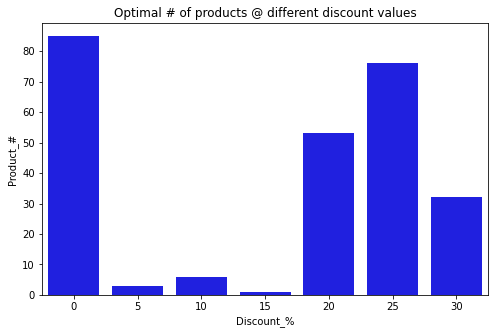

In [203]:
opt_suggestion = opt.groupby('Discount_%').agg({'Optimization_Result' : 'sum'}).reset_index().rename(columns = {'Optimization_Result' : 'Product_#'}) #, 'New_Revenue' : 'sum', 'New_Price' : 'mean'

plt.figure(figsize=(8, 5))
sns.barplot(data = opt_suggestion, x = 'Discount_%', y = 'Product_#', color = 'blue')
plt.title('Optimal # of products @ different discount values')
plt.show()